In [1]:
import os
import sys

if "COLAB_GPU" in os.environ:
  from google.colab import drive
  print("Hello, Colab")
  drive.mount("/content/drive")
  ROOT_PATH = "/content/drive/MyDrive/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
elif "PAPERSPACE_CLUSTER_ID" in os.environ:
  print("Hello, Paperspace")
  ROOT_PATH = "/notebooks/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
else:
  print("Hello, Local PC")
  ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))

EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/emulate-online-scenario"
ARTIFACTS_PATH = f"{EXPERIMENT_PATH}/artifacts"

TCNN_ABILITIES_EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/tcnn-abilities"
TCNN_ABILITIES_ARTIFACTS_PATH = f"{TCNN_ABILITIES_EXPERIMENT_PATH}/artifacts"

sys.path.insert(0, ROOT_PATH)

Hello, Paperspace


In [2]:
from functools import lru_cache
from collections import defaultdict, namedtuple
from json import load, dumps, dump
from itertools import product

import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
import torch
import torch.nn as nn
    
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from src.models import binary_tree_layers as btl
from src.models.regressor import BinaryTreeRegressor
from src.datasets.oracle import Oracle, OracleRequest, TIMEOUT
from src.datasets.data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET
from src.datasets.data_types import ExplainNode
from src.datasets.vectorization import extract_vertices_and_edges, ALL_FEATURES
from src.datasets.binary_tree_dataset import binary_tree_collate, BinaryTreeDataset, WeightedBinaryTreeDataset, weighted_binary_tree_collate, paddify_sequences
from src.utils import get_structure, get_tree, preprocess, featurize_dataset, filter_df, load_run, MAX_TREE_LENGTH, get_logical_tree, get_full_plan

In [3]:
job_oracle = Oracle(f"{ROOT_PATH}/data/processed/JOB")
sq_oracle = Oracle(f"{ROOT_PATH}/data/processed/sample_queries")

In [4]:
job_list_info = torch.load(f"{TCNN_ABILITIES_ARTIFACTS_PATH}/job_list_info")
ood_sq_list_info = torch.load(f"{TCNN_ABILITIES_ARTIFACTS_PATH}/ood_sq_list_info")
id_sq_list_info = torch.load(f"{TCNN_ABILITIES_ARTIFACTS_PATH}/id_sq_list_info")

In [5]:
PROCESSED_EX_TIMES = {
    (info["query_name"], info["hintset"], info["dop"]): info["time"].item()
    for info in job_list_info + ood_sq_list_info + id_sq_list_info
}

# Helpers

Here are small and more convinient reimplementation of basic funcionality.

In [6]:
def _get_selectivities(plan: "ExplainPlan") -> "List[Selectivity]":
    res = []
    def recurse(node: "ExplainNode") -> "None":
        max_possible_size = 1
        current_size = node.estimated_cardinality
        for child in node.plans:
            max_possible_size *= child.estimated_cardinality
        res.append(current_size / max_possible_size)
        for child in node.plans:
            recurse(child)
    recurse(node=plan.plan)
    return res

In [7]:
def _get_cardinalities(plan: "ExplainPlan") -> "List[Cardinality]":
    res = []
    def recurse(node: "ExplainNode") -> "None":
        res.append(node.estimated_cardinality)
        for child in node.plans:
            recurse(child)
    recurse(node=plan.plan)
    return res

In [8]:
@lru_cache(None)
def _get_oracle(q_n: "QueryName") -> "Oracle":
    if q_n in job_oracle.get_query_names():
        return job_oracle
    else:
        return sq_oracle

**remember me**

In [9]:
@lru_cache(None)
def _get_logical_tree(q_n: "QueryName", hs: "Hintset", dop: "Dop") -> "str":
    #return get_full_plan(q_n, _get_oracle(q_n), hs, dop, with_rels=True)
    return get_logical_tree(q_n, _get_oracle(q_n), hs, dop, with_rels=True)

In [10]:
@lru_cache(None)
def _get_execution_time(q_n: "QueryName", hs: "Hintset", dop: "Dop", handle_timeout: "bool" = True) -> "Time":
    time_from_oracle = _get_oracle(q_n).get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop)) / 1000
    if not handle_timeout:
        return time_from_oracle
    if time_from_oracle != TIMEOUT / 1000:
        assert np.isclose(time_from_oracle, PROCESSED_EX_TIMES[(q_n, hs, dop)]), "Inconsistent times"
        return time_from_oracle
    else:
        return PROCESSED_EX_TIMES[(q_n, hs, dop)]

In [11]:
@lru_cache(None)
def _get_planning_time(q_n: "QueryName", hs: "Hintset", dop: "Dop") -> "Time":
    return _get_oracle(q_n).get_planning_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop)) / 1000

In [12]:
@lru_cache(None)
def _get_e2e_time(q_n: "QueryName", hs: "Hintset", dop: "Dop") -> "Time":
    return _get_execution_time(q_n, hs, dop) + _get_planning_time(q_n, hs, dop)

In [13]:
@lru_cache(None)
def _get_explain_plan(q_n: "QueryName", hs: "Hintset", dop: "Dop") -> "ExplainPlan":
    return _get_oracle(q_n).get_explain_plan(OracleRequest(query_name=q_n, hintset=hs, dop=dop))

In [14]:
@lru_cache(None)
def _get_processed_v_e(q_n: "QueryName", hs: "Hintset", dop: "Dop") -> "Tuple[Tensor, Tensor]":
    return preprocess(*extract_vertices_and_edges(_get_explain_plan(q_n, hs, dop)))

In [15]:
def _get_prediction(q_n: "QueryName", hs: "Hintset", dop: "Dop", model: "BinaryTreeRegressor") -> "float":
    with torch.no_grad():
        v, e = _get_processed_v_e(q_n, hs, dop)
        return model(v.unsqueeze(0).to(model.device), e.unsqueeze(0).to(model.device)).squeeze(0).item()    

# Classes

In [16]:
DEFAULT_DOP = 64
DISTANCE_THRESHOLD = 1.1
BOOST_THRESHOLD = 1.1
eps = 1e-10

## Storage

In [21]:
Edge = namedtuple("Edge", ["node_from", "node_to", "boosts", "parameters"])
Node = namedtuple("Node", ["logical_plan", "selectivities", "cardinalities"])
Parameters = namedtuple("Parameters", ["hintset", "dop"])
Prediction = namedtuple("Prediction", ["expected_node", "parameters", "expected_boost"])

In [22]:
@lru_cache(None)
def _make_node(q_n: "QueryName", hs: "Hintset", dop: "Dop") -> "Node":
    plan = _get_explain_plan(q_n, hs, dop)
    return Node(_get_logical_tree(q_n, hs, dop), _get_cardinalities(plan), _get_selectivities(plan))

In [256]:
class Storage:
    def __init__(self, default_hintset: "Hintset" = DEFAULT_HINTSET, default_dop: "Dop" = DEFAULT_DOP):
        self.logical_plan_to_edges = defaultdict(list)
        self.threshold = DISTANCE_THRESHOLD
        self.default_hintset = default_hintset
        self.default_dop = default_dop

    @staticmethod
    def get_distance(x: "Node", y: "Node") -> "float":
        if x.logical_plan != y.logical_plan:
            return float("inf")
        return max(
            max([max(xi/yi, yi/xi) for xi, yi in zip(x.cardinalities, y.cardinalities)]),
            max([max(xi/yi, yi/xi) for xi, yi in zip(x.selectivities, y.selectivities)]),
        )

    def add_info(self, node_from: "Node", node_to: "Node", boost: "float", parameters: "Parameters") -> "None":
        new_edge = Edge(node_from, node_to, [boost], [parameters])

        if node_from.logical_plan not in self.logical_plan_to_edges:
            self.logical_plan_to_edges[node_from.logical_plan].append(new_edge)
            return 

        for edge in self.logical_plan_to_edges[node_from.logical_plan]:
            if edge.node_from == node_from and edge.node_to == node_to:
                #print(f"Found collision. Adding {boost:0.3f} to {[round(v, 3) for v in edge.boosts]}")
                edge.boosts.append(boost)
                edge.parameters.append(parameters)
                break
        else:
            self.logical_plan_to_edges[node_from.logical_plan].append(new_edge)

    def _get_relevant_edges(self, node: "Node") -> "List[Edge]":
        min_dist, argmin = float("inf"), None
        for cur_edge in self.logical_plan_to_edges[node.logical_plan]: 
            cur_dist = self.get_distance(cur_edge.node_from, node)
            if cur_dist < min_dist and cur_dist < self.threshold:
                min_dist, argmin = cur_dist, cur_edge.node_from
        if argmin and len(self.logical_plan_to_edges[argmin.logical_plan]) > 1:
            edges = self.logical_plan_to_edges[argmin.logical_plan]
            #print(f"{len(edges)} edges, {list(edge.boosts for edge in edges)}")
        return [] if argmin is None else self.logical_plan_to_edges[argmin.logical_plan]

    def predict(self, node: "Node") -> "Prediction":
        max_boost, argmax = float("-inf"), None
        for cur_edge in self._get_relevant_edges(node):
            cur_boost = np.mean(cur_edge.boosts)
            if cur_boost > max_boost:
                max_boost, argmax = cur_boost, cur_edge
                
        if argmax is None:
            return Prediction(node, Parameters(self.default_hintset, self.default_dop), 1.0)
        else:
            return Prediction(argmax.node_to, argmax.parameters[0], max_boost)
        
    def validate(self, obtained_node: "Node", prediction: "Prediction") -> "bool":
        return self.get_distance(obtained_node, prediction.expected_node) <= self.threshold

    def estimate_edge(self, node_from: "Node", obtained_node: "Node") -> "float":
        max_boost = float("-inf")
        for cur_edge in self._get_relevant_edges(node_from):
            if self.get_distance(obtained_node, cur_edge.node_to) > self.threshold:
                continue
            max_boost = max(max_boost, np.mean(cur_edge.boosts))
        return max_boost

### small tests

In [257]:
node_from1 = Node(logical_plan="<plan_from1>", selectivities=[0.1], cardinalities=[1])

node_to1 = Node(logical_plan="<plan_to1>", selectivities=[0.5], cardinalities=[2])
node_to1_close = Node(logical_plan="<plan_to1>", selectivities=[0.5 * (DISTANCE_THRESHOLD-eps)], cardinalities=[2 * (DISTANCE_THRESHOLD-eps)])
node_to1_far = Node(logical_plan="<plan_to1>", selectivities=[0.5 * (DISTANCE_THRESHOLD+eps)], cardinalities=[2 * (DISTANCE_THRESHOLD+eps)])

node_to2 = Node(logical_plan="<plan_to2>", selectivities=[0.5, 0.7], cardinalities=[2, 4])


st = Storage()

st.add_info(node_from=node_from1, node_to=node_to1, boost=10, parameters=Parameters(1, 666))
st.add_info(node_from=node_from1, node_to=node_to2, boost=100, parameters=Parameters(2, 777))
prediction = st.predict(node_from1)
assert prediction.expected_node == node_to2, "Incorrect prediction"
assert prediction.expected_boost == 100, "Incorrect prediction"
assert prediction.parameters == Parameters(2, 777), "Incorrect prediction"
assert st.validate(obtained_node=node_to2, prediction=prediction) == True, "Wrong prediction validation"
assert st.validate(obtained_node=node_to1, prediction=prediction) == False, "Wrong prediction validation"
print("[default scenario]: all works as expected")

st.add_info(node_from=node_from1, node_to=node_to1, boost=1000, parameters=Parameters(1, 6666))
prediction = st.predict(node_from1)
assert prediction.expected_node == node_to1, "Incorrect prediction"
assert prediction.expected_boost == (10 + 1000) / 2, "Incorrect prediction"
assert prediction.parameters in {Parameters(1, 666), Parameters(1, 6666)}, "Incorrect prediction"
assert st.validate(obtained_node=node_to1, prediction=prediction) == True, "Wrong prediction validation"
assert st.validate(obtained_node=node_to1_close, prediction=prediction) == True, "Wrong prediction validation"
assert st.validate(obtained_node=node_to1_far, prediction=prediction) == False, "Wrong prediction validation"
print("[collision scenario]: all works as expected")

unknown_node = Node(logical_plan="<unknown_plan>", selectivities=[0.42], cardinalities=[42])
prediction = st.predict(unknown_node)
assert prediction.expected_node == unknown_node, "Incorrect prediction"
assert prediction.expected_boost == 1.0, "Incorrect prediction"
assert prediction.parameters == Parameters(DEFAULT_HINTSET, DEFAULT_DOP), "Incorrect prediction"
print("[unknown node scenario]: all works as expected")

[default scenario]: all works as expected
[collision scenario]: all works as expected
[unknown node scenario]: all works as expected


## Explorer

In [25]:
SearchingState = namedtuple(
    "SearchingState", 
    ["hintset", "dop"], 
    defaults=[DEFAULT_HINTSET, DEFAULT_DOP]
)

In [26]:
SearchingSettings = namedtuple(
    "SearchingSettings", 
    [
        "disable_ops",
        "decrease_dop", 
        "disable_inl",
        "boost_threshold", 
        "max_iter", 
        "use_joined_search",
        "force_join",
        "force_only_nl",
        "fast_mode",
        "default_hintset",
        "default_dop",
        "hardcoded_hintsets",
        "hardcoded_dops",
    ],
    defaults=[
        False, 
        False, 
        False, 
        1.0, 
        1,
        False,
        False,
        False,
        False,
        DEFAULT_HINTSET,
        DEFAULT_DOP,
        None,
        None,
    ]    
)

In [129]:
EMPTY_SS = SearchingSettings(
    hardcoded_hintsets=[],
    hardcoded_dops=[],
)

GREEDY_DEF_DOP_SS = SearchingSettings(
    disable_ops=True,
    max_iter=float("inf"),
)

PRUNED_GREEDY_DEF_DOP_SS = SearchingSettings(
    disable_ops=True,
    max_iter=1,
)

GREEDY_SS = SearchingSettings(
    disable_ops=True,
    decrease_dop=True,
    max_iter=float("inf"),
)

PRUNED_GREEDY_SS = SearchingSettings(
    disable_ops=True,
    decrease_dop=True,
    max_iter=1,
)

LOCAL_DEF_DOP_SS = SearchingSettings(
    disable_ops=True,
    disable_inl=True,
    force_join=True,
    force_only_nl=True,
    max_iter=float("inf"),
)

PRUNED_ECONOM_DEF_DOP_SS = SearchingSettings(
    disable_inl=True,
    force_join=True,
    max_iter=1
)

ECONOM_DEF_DOP_SS = SearchingSettings(
    disable_inl=True,
    force_join=True,
    max_iter=float("inf"),
)

PRUNED_ECONOM_SS = SearchingSettings(
    disable_inl=True,
    force_join=True,
    use_joined_search=True,
    max_iter=1,
)

ECONOM_SS = SearchingSettings(
    disable_inl=True,
    force_join=True,
    use_joined_search=True,
    max_iter=float("inf"),
)


PRUNED_LOCAL_SS = SearchingSettings(
    disable_ops=True,
    disable_inl=True,
    force_join=True,
    force_only_nl=True,
    max_iter=1,
)


PRUNED_LOCAL_DEF_DOP_SS = SearchingSettings(
    disable_ops=True,
    disable_inl=True,
    force_join=True,
    force_only_nl=True,
    max_iter=1,
)


PRUNED_LOCAL_SS = SearchingSettings(
    disable_ops=True,
    decrease_dop=True,
    disable_inl=True,
    use_joined_search=True,
    force_join=True,
    force_only_nl=True,
    max_iter=1,
)

LOCAL_SS = SearchingSettings(
    disable_ops=True,
    decrease_dop=True,
    disable_inl=True,
    use_joined_search=True,
    force_join=True,
    force_only_nl=True,
    max_iter=float("inf"),
)

ALL_SS = SearchingSettings(
    hardcoded_hintsets=HINTSETS,
    hardcoded_dops=DOPS,
)

ALL_DEF_DOP_SS = SearchingSettings(
    hardcoded_hintsets=HINTSETS,
    hardcoded_dops=[DEFAULT_DOP],
)

In [28]:
OFF_INL_HINT = 64 | 8 | 2
N_SCANS = 4
N_JOINS = 3
NL_POS = 2
assert N_SCANS + N_JOINS == len(HINTS)

In [141]:
class QueryExplorer:
    def __init__(
        self, 
        query_name: "QueryName", 
        settings: "SearchingSettings", 
        ranking_model: "Optional[BinaryTreeRegressor]" = None, 
        execution_model: "Optional[BinaryTreeRegressor]" = None, 
    ):
        self.query_name = query_name
        self.settings = settings

        self.ranking_model = ranking_model
        self.execution_model = execution_model

        self.learning_time = 0
        self.n_executions = 0
        self.n_plannings = 0

        self.explored_states = set()
        self.explored_trees = set()
        self.planned_trees = set()

    def explore_state(self, state: "SearchingState", timeout: "Time" = float("inf")) -> "Time":
        tree = _get_logical_tree(self.query_name, *state)
        plan_time = _get_planning_time(self.query_name, *state)
        self.learning_time += min(timeout, plan_time)
            
        if self.execution_model:
            ex_time = _get_prediction(self.query_name, *state, self.execution_model)
        else:
            ex_time = _get_execution_time(self.query_name, *state, handle_timeout=False)
        
        self.learning_time += max(min(ex_time, timeout - plan_time), 0) * int(not self.execution_model and tree not in self.explored_trees)
        self.explored_trees.add(tree)
        self.n_executions += int(not self.execution_model)
        return plan_time + ex_time if ex_time + plan_time < timeout else float("inf")


    def run(self) -> "SearchingState":
        def_state = SearchingState(self.settings.default_hintset, self.settings.default_dop)
        prev_state, record_state = None, def_state
        
        def_time = self.explore_state(state=def_state)
        minimal_inference_cost = _get_planning_time(self.query_name, self.settings.default_hintset, self.settings.default_dop)
        record_time = def_time -minimal_inference_cost #?
        
        self.explored_states.add(def_state)
        self._parallel_planning_time = self._total_planning_time = .0
        

        it = 0
        while it < self.settings.max_iter:
            timeout, prev_state = record_time / self.settings.boost_threshold, record_state
            neighbors = list(filter(lambda st: st not in self.explored_states, self.get_neighbors(state=record_state)))

            PLAN_TIMES.append(list((it, self.query_name, hs, dop, _get_planning_time(self.query_name, hs, dop)) for hs, dop in neighbors))

            max_plan_time_in_batch = max((_get_planning_time(self.query_name, st.hintset, st.dop) for st in neighbors), default=0)
            total_plan_time_in_batch = sum((_get_planning_time(self.query_name, st.hintset, st.dop) for st in neighbors))
            
            if it == 0: 
                max_plan_time_in_batch = max(max_plan_time_in_batch, _get_planning_time(self.query_name, self.settings.default_hintset, self.settings.default_dop))
                total_plan_time_in_batch += _get_planning_time(self.query_name, self.settings.default_hintset, self.settings.default_dop)
            
            self._parallel_planning_time += max_plan_time_in_batch
            self._total_planning_time += total_plan_time_in_batch

            if self.ranking_model:
                neighbors = sorted(neighbors, key=lambda st: _get_prediction(self.query_name, st.hintset, st.dop, self.ranking_model))
            
            for ngb_state in neighbors:
                ngb_time = self.explore_state(state=ngb_state, timeout=timeout)
                self.explored_states.add(ngb_state)
                if record_time / ngb_time > self.settings.boost_threshold:
                    record_state, record_time = ngb_state, ngb_time
                    if self.settings.fast_mode:
                        break
            
            it += 1
            if prev_state == record_state:
                break  
        
        return record_state

    def get_neighbors(self, state: "SearchingState") -> "List[SearchingState]":    
        current_dop, current_hintset = state.dop, state.hintset
        neighbors = set()

        if self.settings.use_joined_search:
            to_try_dops = DOPS
        else:
            to_try_dops = [current_dop]
        
        for dop in to_try_dops:
            if self.settings.disable_ops:
                for op_num in range(len(HINTS)):
                    neighbors.add(SearchingState(dop=dop, hintset=current_hintset | (1 << op_num)))

            if self.settings.disable_inl:
                neighbors.add(SearchingState(dop=dop, hintset=current_hintset | (OFF_INL_HINT)))

            if self.settings.decrease_dop:
                for new_dop in [new_dop for new_dop in DOPS if new_dop < dop]:
                    neighbors.add(SearchingState(dop=new_dop, hintset=current_hintset))                    
            
            if self.settings.force_join:
                for join_num in range(N_JOINS):
                    saved_scans = ((1 << N_SCANS) - 1) & current_hintset
                    only_one_join = (((1 << N_JOINS) - 1) - (1 << join_num)) << N_SCANS
                    neighbors.add(SearchingState(dop=dop, hintset=only_one_join|saved_scans))

            if self.settings.force_only_nl:
                join_num = NL_POS
                saved_scans = ((1 << N_SCANS) - 1) & current_hintset
                only_one_join = (((1 << N_JOINS) - 1) - (1 << join_num)) << N_SCANS
                neighbors.add(SearchingState(dop=dop, hintset=only_one_join|saved_scans))                    

        return neighbors        

## Model

### Interface

In [243]:
class Model:
    def __init__(
        self, 
        fit_settings: "SearchingSettings", 
        inference_settings: "Opitonal[SearchingSettings]" = None, 
        ranking_model: "Optional[BinaryTreeRegressor]" = None, 
        execution_model: "Optional[BinaryTreeRegressor]" = None,
    ):
        self.fit_settings = fit_settings
        self.inference_settings = inference_settings
        self.ranking_model = ranking_model
        self.execution_model = execution_model
        self.default_hintset = self.fit_settings.default_hintset
        self.default_dop = self.fit_settings.default_dop

    def validate(self, query_name: "QueryName", prediction: "Prediction") -> "Tuple[Time, bool]":
        raise NotImplementedError        

    def predict(self, query_name: "QueryName") -> "Tuple[Time, Prediction]":
        raise NotImplementedError        

    def fit(self, list_q_n: "List[QueryName]") -> "Time":
        raise NotImplementedError

### Hero

In [244]:
class Hero(Model):
    def __init__(
        self, 
        fit_settings: "SearchingSettings", 
        inference_settings: "Opitonal[SearchingSettings]" = None, 
        ranking_model: "Optional[BinaryTreeRegressor]" = None, 
        execution_model: "Optional[BinaryTreeRegressor]" = None,
    ):
        super().__init__(fit_settings, inference_settings, ranking_model, execution_model)
        self.storage = Storage()

    def predict(self, query_name: "QueryName") -> "Tuple[Time, Prediction]":
        inference_time = _get_planning_time(query_name, self.default_hintset, self.default_dop)
        prediction = self.storage.predict(_make_node(query_name, self.default_hintset, self.default_dop))
        return inference_time, prediction

    def validate(self, query_name: "QueryName", prediction: "Prediction") -> "Tuple[Time, bool]":
        node_from = _make_node(query_name, self.default_hintset, self.default_dop)
        validation_time = _get_planning_time(query_name, prediction.parameters.hintset, prediction.parameters.dop)
        obtained_node = _make_node(query_name, prediction.parameters.hintset, prediction.parameters.dop)
        # todo
        is_prediction_save = self.storage.validate(obtained_node, prediction) and prediction.expected_boost > BOOST_THRESHOLD
        is_prediction_save |= self.storage.estimate_edge(node_from=node_from, obtained_node=obtained_node) > BOOST_THRESHOLD
        return validation_time, is_prediction_save

    def fit(self, list_q_n: "List[QueryName]") -> "Time":
        return sum(self.explore(q_n) for q_n in list_q_n)

    def explore(self, query_name: "QueryName") -> "Time":
        explorer = QueryExplorer(query_name, self.fit_settings, self.ranking_model, self.execution_model)
        hs, dop = explorer.run()
        node_from, node_to = _make_node(query_name, self.default_hintset, self.default_dop), _make_node(query_name, hs, dop)
        if (hs, dop) != (DEFAULT_HINTSET, DEFAULT_DOP):
            boost = _get_e2e_time(query_name, self.default_hintset, self.default_dop) - (_get_e2e_time(query_name, hs, dop) + _get_planning_time(query_name, self.default_hintset, self.default_dop))
            self.storage.add_info(node_from, node_to, boost, Parameters(hs, dop))
        return explorer.learning_time

In [245]:
PLAN_TIMES = []
q_n = "16b"
heromodel = Hero(fit_settings=LOCAL_SS)
print(f"Learned in {heromodel.fit([q_n]):0.2f} sec") 
inference_time, pred_after = heromodel.predict(q_n)
print(f"Inference time is {inference_time:0.2f} sec")
def_time = _get_e2e_time(q_n, heromodel.fit_settings.default_hintset, heromodel.fit_settings.default_dop)
custom_time = _get_e2e_time(q_n, pred_after.parameters.hintset, pred_after.parameters.dop)
print(f"Query {q_n} has been optimized on {def_time - custom_time:0.3f} sec ({def_time:0.3f} -> {custom_time:0.3f})")

Learned in 822.19 sec
Inference time is 0.37 sec
Query 16b has been optimized on 40.212 sec (69.970 -> 29.758)


### NN

In [246]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {DEVICE}")

device is cuda


In [44]:
batch_size = 32
lr = 3e-4
in_channels = len(ALL_FEATURES)

In [45]:
big_btcnn_and_instance_norm = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeInstanceNorm(128),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeInstanceNorm(256),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

bt_regressor = lambda name: BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn(), name=name, device=DEVICE)

In [46]:
def load_model(device, path):
    ckpt_path=path
    ckpt_state = torch.load(ckpt_path, map_location=device)
    model = BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn())
    model.load_state_dict(ckpt_state["model_state_dict"])
    model = model.to(device)
    model.device = device
    return model

In [47]:
def save_ckpt(model, optimizer, scheduler, epoch, path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state, path)

In [48]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [49]:
def calculate_loss(model, optimizer, criterion, dataloader, train_mode=True):
    model.train() if train_mode else model.eval()
    running_loss, total_samples = .0, 0
    for (vertices, edges, freq), time in dataloader:
        if train_mode:
            optimizer.zero_grad()
        
        outputs = model(vertices, edges)
        weighted_loss = (freq.float().squeeze(-1) * criterion(outputs.squeeze(-1), time)).mean()
        
        if train_mode:
            weighted_loss.backward()
            optimizer.step()

        running_loss += weighted_loss.item() * vertices.size(0)
        total_samples += freq.sum()
    return running_loss / total_samples

In [50]:
def weighted_train_loop(
    model,  optimizer,  criterion, scheduler, train_dataloader, num_epochs,
    start_epoch=0, ckpt_period=10, path_to_save=None
    ):         
        tqdm_desc = "Initialization"
        progress_bar = tqdm(range(start_epoch + 1, start_epoch + num_epochs + 1), desc=tqdm_desc, leave=True, position=0)
        for epoch in progress_bar:
            train_loss = calculate_loss(model, optimizer, criterion, train_dataloader)
            scheduler.step(train_loss)
            progress_bar.set_description(f"[{epoch}/{start_epoch + num_epochs}] MSE: {train_loss:.4f}")
            if path_to_save and not epoch % ckpt_period:
                save_ckpt(model, optimizer, scheduler, epoch, path_to_save)

In [248]:
class NN(Model):
    def __init__(
        self, 
        fit_settings: "SearchingSettings", 
        model: "BinaryTreeRegressor",
        inference_settings: "SearchingSettings" = SearchingSettings(), 
        ranking_model: "Optional[BinaryTreeRegressor]" = None, 
        execution_model: "Optional[BinaryTreeRegressor]" = None,
    ):
        super().__init__(fit_settings, inference_settings, ranking_model, execution_model)
        self.list_vertices, self.list_edges, self.list_times = [], [], []
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=20)
        self.seen = set()
        self.list_vertices, self.list_edges = [], []
        self.list_times = []

    def fit(self, list_q_n: "List[QueryNames]", epochs: "int" = 100) -> "Time":
        learning_time, history = self.explore_and_get_history(list_q_n)
        self._add_history(history)
        self._update_model(epochs)
        return learning_time
        
    def predict(self, query_name: "QueryName") -> "Tuple[Time, Prediction]":
        if self.inference_settings.hardcoded_hintsets and self.inference_settings.hardcoded_dops:
            inference_time, hs, dop = self._get_exhaustive_prediction(query_name, self.inference_settings.hardcoded_hintsets, self.inference_settings.hardcoded_dops)
        else:
            inference_time, hs, dop = self.get_local_search_prediction(query_name)
        node_to = _make_node(query_name, hs, dop)
        expected_boost = _get_prediction(query_name, self.default_hintset, self.default_dop, self.model) - _get_prediction(query_name, hs, dop, self.model)
        return inference_time, Prediction(node_to, Parameters(hs, dop), expected_boost)

    def validate(self, query_name: "QueryName", prediction: "Prediction") -> "Tuple[Time, bool]":        
        return .0, True

    def get_local_search_prediction(self, query_name: "QueryName") -> "Tuple[Time, Hintset, Dop]":
        explorer = QueryExplorer(query_name, self.inference_settings, execution_model=self.model)
        hs, dop = explorer.run()
        return explorer._parallel_planning_time, hs, dop

    def _get_exhaustive_prediction(self, query_name: "QueryName", hintsets: "List[Hintset]", dops: "List[Dop]") -> "Tuple[Time, Hintset, Dop]":
        """special version of prediction for avoiding local search exploration and abusing the batch processing"""
        v_list, e_list = [], []
        parameters = []
        planning_times = []

        for hs in hintsets:
            for dop in dops:
                v, e = _get_processed_v_e(query_name, hs, dop)
                v_list.append(v), e_list.append(e)
                planning_times.append(_get_planning_time(query_name, hs, dop))
                parameters.append(Parameters(hs, dop))

        with torch.no_grad():
            v_batch, e_batch = torch.stack(v_list).to(self.model.device), torch.stack(e_list).to(self.model.device)
            predicted_times = self.model(v_batch, e_batch).squeeze(1).cpu().numpy()
            total_times = predicted_times + planning_times
            
        return float(sum(planning_times)), *parameters[total_times.argmin()]

    def explore_and_get_history(self, list_q_n: "List[QueryNames]") -> "Tuple[Time, List[Tuple[QueryName, Hintset, Dop]]]":
        if self.fit_settings.hardcoded_hintsets and self.fit_settings.hardcoded_dops:
            return self._explore_and_get_exhaustive_history(list_q_n, self.fit_settings.hardcoded_hintsets, self.fit_settings.hardcoded_dops)
        learning_time = .0
        history = []
        for q_n in list_q_n:
            explorer = QueryExplorer(q_n, self.fit_settings)
            explorer.run()
            learning_time += explorer.learning_time
            for hs, dop in explorer.explored_states:
                history.append((q_n, hs, dop))
        return learning_time, history

    def _explore_and_get_exhaustive_history(self, list_q_n: "QueryName", hintsets: "List[Hintset]", dops: "List[Dop]") -> "Tuple[Time, List[Tuple[QueryName, Hintset, Dop]]]":
        """special version of prediction for avoiding the local search exploration"""
        planning_time = .0
        ex_time = .0
        exhaustive_history = []
        for q_n in list_q_n:
            seen_trees = set()
            for hs in hintsets:
                for dop in dops:
                    exhaustive_history.append((q_n, hs, dop))
                    planning_time += _get_planning_time(q_n, hs, dop)
                    tree = _get_logical_tree(q_n, hs, dop)
                    ex_time += _get_execution_time(q_n, hs, dop) * (tree not in seen_trees)
                    seen_trees.add(tree)
        return planning_time + ex_time, exhaustive_history

    def _add_history(self, history: "List[Tuple[QueryName, Hintset, Dop]]") -> "None":
        for q_n, hs, dop in history:
            if (q_n, hs, dop) in self.seen:
                continue
            self.seen.add((q_n, hs, dop))
            v, e = extract_vertices_and_edges(_get_explain_plan(q_n, hs, dop))
            time = _get_e2e_time(q_n, hs, dop)
            self.list_vertices.append(v), self.list_edges.append(e)
            self.list_times.append(torch.Tensor([time]))
        self._prepare_dataloader()        

    def _prepare_dataloader(self) -> "None":
        self.dataloader = DataLoader(
            dataset=WeightedBinaryTreeDataset(self.list_vertices, self.list_edges, self.list_times, self.model.device), 
            batch_size=batch_size, 
            shuffle=True,
            collate_fn=lambda el: weighted_binary_tree_collate(el, MAX_TREE_LENGTH),
            drop_last=False
        )
        print(f"Dataset's size is {len(self.dataloader.dataset)} | Dataloader's size is {len(self.dataloader)}")  

    def _update_model(self, epochs: "int") -> "None":
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=20)
        set_seed(2024)
        weighted_train_loop(
            model=self.model,
            optimizer=self.optimizer,
            criterion=nn.MSELoss(reduction="none"),
            scheduler=self.scheduler,
            train_dataloader=self.dataloader,
            num_epochs=epochs,
            ckpt_period=epochs,
            path_to_save=f"{EXPERIMENT_PATH}/models/{self.model.name}.pth",
        )

In [249]:
q_n = "16b"
nnmodel = NN(fit_settings=ALL_SS, inference_settings=ALL_SS, model=bt_regressor("dummy_nn"))
print(f"Learned in {nnmodel.fit([q_n], epochs=300):0.2f} sec") 
inference_time, pred_after = nnmodel.predict(q_n)
print(f"Inference time is {inference_time:0.2f} sec [expected boost is {pred_after.expected_boost:0.3f}]")
def_time = _get_e2e_time(q_n, nnmodel.fit_settings.default_hintset, nnmodel.fit_settings.default_dop)
custom_time = _get_e2e_time(q_n, pred_after.parameters.hintset, pred_after.parameters.dop)
print(f"Query {q_n} has been optimized on {def_time - custom_time:0.3f} sec ({def_time:0.3f} -> {custom_time:0.3f})")

Dataset's size is 71 | Dataloader's size is 1


[300/300] MSE: 0.0449: 100%|██████████| 300/300 [00:05<00:00, 51.39it/s]  


Learned in 4208.32 sec
Inference time is 63.37 sec [expected boost is 39.714]
Query 16b has been optimized on 40.212 sec (69.970 -> 29.758)


In [250]:
nnmodel.inference_settings = LOCAL_SS
inference_time, pred_after = nnmodel.predict(q_n)
print(f"[with local search] Inference time is {inference_time:0.2f} sec [expected boost is {pred_after.expected_boost:0.3f}]")
def_time = _get_e2e_time(q_n, nnmodel.fit_settings.default_hintset, nnmodel.fit_settings.default_dop)
custom_time = _get_e2e_time(q_n, pred_after.parameters.hintset, pred_after.parameters.dop)
print(f"Query {q_n} has been optimized on {def_time - custom_time:0.3f} sec ({def_time:0.3f} -> {custom_time:0.3f})")

[with local search] Inference time is 1.96 sec [expected boost is 39.714]
Query 16b has been optimized on 40.212 sec (69.970 -> 29.758)


# Evaluation

In [54]:
def get_report(model, test_q_n, safe_mode=False):
    """one useful property: all our models build resulting plans during inference"""
    report = {
        "default_ex_time": .0,
        "default_planning_time": .0,
        "custom_ex_time": .0,
        "inference_time": .0,
        "n_timeouts": .0,
        "boosts": [],
        "predictions": [],
        "n_false_validations": 0,
        "possible_regressions": [],
    }
    
    for q_n in tqdm(test_q_n):
        inference_time, prediction = model.predict(q_n)
        hs, dop = prediction.parameters
        if safe_mode: 
            validation_time, is_valid = model.validate(q_n, prediction)
            inference_time += validation_time
            if not is_valid:
                report["n_false_validations"] += 1
                report["possible_regressions"].append((q_n, hs, dop, _get_e2e_time(q_n, hs, dop) - _get_e2e_time(q_n, model.default_hintset, model.default_dop)))
                hs, dop = model.default_hintset, model.default_dop

        report["default_ex_time"] += _get_execution_time(q_n, model.default_hintset, model.default_dop)
        report["custom_ex_time"] += _get_execution_time(q_n, hs, dop)

        report["default_planning_time"] += _get_planning_time(q_n, model.default_hintset, model.default_dop)
        report["inference_time"] += inference_time
        report["predictions"].append((q_n, hs, dop))
        report["boosts"].append(_get_e2e_time(q_n, model.default_hintset, model.default_dop) - _get_e2e_time(q_n, hs, dop))
        if _get_execution_time(q_n, hs, dop, handle_timeout=False) == TIMEOUT / 1000:
            report["n_timeouts"] += 1        
            #assert report["boosts"][-1] <= 0,  
            #print(q_n, hs, dop)
    
    return report

In [55]:
all_queries = job_oracle.get_query_names()
id_queries = list(set(info["query_name"] for info in id_sq_list_info))
ood_queries = list(set(info["query_name"] for info in ood_sq_list_info))
assert len(id_queries) + len(ood_queries) == len(sq_oracle.get_query_names())
print(f"# queries\nJOB: {len(all_queries)}\nSQ [id]: {len(id_queries)}\nSQ [ood]: {len(ood_queries)}")

# queries
JOB: 113
SQ [id]: 13
SQ [ood]: 27


In [195]:
for _ in range(1):
    def_ex = sum(_get_execution_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in job_oracle.get_query_names())
    def_e2e = sum(_get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in job_oracle.get_query_names())

    predictions = {}
    s, s_e2e = 0, 0
    opt, opt_e2e = 0, 0

    for q_n in job_workload:#["27c"]:
        hero = Hero(GREEDY_SS)
        hero.fit([q_n])
        hs, dop = hero.predict(q_n)[1].parameters

        predictions[q_n] = hs, dop
        
        s += _get_execution_time(q_n, hs, dop)
        s_e2e += _get_e2e_time(q_n, hs, dop)
        opt += min(_get_execution_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS)
        opt_e2e += min(_get_e2e_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS)

In [192]:
#s, opt, s_e2e, opt_e2e, (def_ex - s)/(def_ex-opt), (def_e2e - s_e2e)/(def_e2e-opt_e2e), 

(249.46948500000008,
 162.70199200000002,
 266.568485,
 187.85634300009,
 0.7034382760831334,
 0.780648264193357)

# Ideal case

In [158]:
job_workload = job_oracle.get_query_names()
sq_workload = sq_oracle.get_query_names()

In [159]:
batch_size = 128

ideal_job_model = NN(fit_settings=ALL_SS, inference_settings=EMPTY_SS, model=bt_regressor("ideal_job"))
ideal_job_model.model = load_model(device=DEVICE, path=f"{EXPERIMENT_PATH}/models/ideal_job.pth")
#ideal_job_model.fit(job_workload, 500)

ideal_sq_model = NN(fit_settings=ALL_SS, inference_settings=EMPTY_SS, model=bt_regressor("ideal_sq"))
ideal_sq_model.model = load_model(device=DEVICE, path=f"{EXPERIMENT_PATH}/models/ideal_sq.pth")
#ideal_sq_model.fit(sq_workload, 500)

workloads = [job_workload, sq_workload]
workload_names = ["JOB", "SQ"]
ideal_models = [ideal_job_model, ideal_sq_model]

### small trash

In [106]:
# GREEDY_PLAN_TIMES = PLAN_TIMES
LOCAL_PLAN_TIMES = PLAN_TIMES

In [117]:
for l in sorted(LOCAL_PLAN_TIMES, key=lambda l: max((t[-1] for t in l), default=0), reverse=True):
    x = sorted(l, key=lambda v: v[-1], reverse=True)[:1]
    if x:
        print(x[0])


(0, '29c', 2, 64, 9.691)
(0, '29a', 74, 64, 7.38)
(0, '29b', 74, 64, 7.339)
(1, '31c', 75, 64, 5.688)
(0, '26c', 2, 64, 5.663)
(3, '29a', 91, 64, 5.585)
(0, '27c', 74, 64, 5.146)
(0, '26a', 2, 64, 5.007)
(0, '24a', 2, 64, 4.911)
(0, '27a', 74, 64, 4.846)
(0, '27b', 74, 64, 4.721)
(0, '28b', 2, 64, 4.646)
(0, '28a', 2, 64, 4.61)
(0, '30a', 2, 64, 4.509)
(0, '30c', 2, 64, 4.434)
(0, '26b', 2, 64, 4.415)
(0, '28c', 2, 64, 4.406)
(2, '29c', 104, 64, 4.285)
(0, '24b', 74, 64, 4.285)
(0, '30b', 2, 64, 3.837)
(4, '27a', 110, 64, 3.794)
(2, '27a', 106, 64, 3.788)
(0, '33a', 64, 64, 3.753)
(0, '33b', 64, 64, 3.643)
(1, '29c', 50, 64, 3.512)
(0, '33c', 64, 64, 3.331)
(2, '29a', 81, 64, 3.316)
(2, '27b', 88, 64, 2.967)
(1, '29a', 50, 64, 2.807)
(2, '27c', 88, 64, 2.778)
(2, '29b', 114, 64, 2.743)
(1, '29b', 50, 64, 2.731)
(2, '33b', 88, 64, 2.636)
(3, '26c', 91, 64, 2.633)
(3, '33b', 92, 64, 2.609)
(4, '26a', 95, 64, 2.537)
(3, '26a', 91, 64, 2.524)
(2, '33a', 81, 64, 2.455)
(3, '33a', 89, 64, 2.

In [118]:
for l in sorted(GREEDY_PLAN_TIMES, key=lambda l: max((t[-1] for t in l), default=0), reverse=True):
    x = sorted(l, key=lambda v: v[-1], reverse=True)[:1]
    if x:
        print(x[0])

(0, '29c', 2, 64, 9.691)
(0, '29a', 2, 64, 7.18)
(0, '29b', 2, 64, 6.869)
(1, '29a', 34, 64, 6.145)
(3, '31c', 75, 64, 5.688)
(0, '26c', 2, 64, 5.663)
(1, '26c', 34, 64, 5.163)
(0, '26a', 2, 64, 5.007)
(0, '24a', 2, 64, 4.911)
(1, '29c', 18, 64, 4.9)
(0, '28b', 2, 64, 4.646)
(0, '28a', 2, 64, 4.61)
(0, '30a', 2, 64, 4.509)
(0, '30c', 2, 64, 4.434)
(0, '26b', 2, 64, 4.415)
(0, '28c', 2, 64, 4.406)
(1, '26b', 34, 64, 4.016)
(0, '27c', 2, 64, 3.88)
(1, '29b', 18, 64, 3.853)
(0, '24b', 2, 64, 3.852)
(0, '30b', 2, 64, 3.837)
(0, '27b', 64, 64, 3.794)
(0, '33a', 64, 64, 3.753)
(0, '27a', 64, 64, 3.651)
(0, '33b', 64, 64, 3.643)
(2, '29c', 50, 64, 3.512)
(1, '28a', 65, 64, 3.423)
(0, '33c', 64, 64, 3.331)
(1, '27c', 34, 64, 3.202)
(1, '27b', 34, 64, 3.007)
(2, '30b', 11, 64, 2.986)
(1, '28b', 18, 64, 2.887)
(2, '29a', 50, 64, 2.807)
(3, '29b', 114, 64, 2.743)
(1, '33b', 34, 64, 2.734)
(2, '29b', 50, 64, 2.731)
(1, '27a', 34, 64, 2.675)
(1, '30b', 5, 64, 2.655)
(1, '28c', 18, 64, 2.58)
(1, '30

In [101]:
sum(max((t[-1] for t in l), default=0) for l in PLAN_TIMES)

129.42

In [98]:
sorted(PLAN_TIMES, key=lambda l: max((t[-1] for t in l), default=0), reverse=True)

[[(0, '29c', 4, 64, 6.383),
  (0, '29c', 16, 64, 3.367),
  (0, '29c', 2, 64, 9.691),
  (0, '29c', 8, 64, 6.08),
  (0, '29c', 74, 64, 7.921),
  (0, '29c', 96, 64, 4.089),
  (0, '29c', 64, 64, 5.934),
  (0, '29c', 80, 64, 3.312),
  (0, '29c', 32, 64, 4.476),
  (0, '29c', 48, 64, 1.246),
  (0, '29c', 1, 64, 5.108)],
 [(0, '29a', 4, 64, 5.747),
  (0, '29a', 16, 64, 3.065),
  (0, '29a', 2, 64, 7.18),
  (0, '29a', 8, 64, 5.739),
  (0, '29a', 74, 64, 7.38),
  (0, '29a', 96, 64, 3.514),
  (0, '29a', 64, 64, 5.767),
  (0, '29a', 80, 64, 3.224),
  (0, '29a', 32, 64, 3.933),
  (0, '29a', 48, 64, 1.319),
  (0, '29a', 1, 64, 5.095)],
 [(0, '29b', 4, 64, 5.642),
  (0, '29b', 16, 64, 3.085),
  (0, '29b', 2, 64, 6.869),
  (0, '29b', 8, 64, 5.543),
  (0, '29b', 74, 64, 7.339),
  (0, '29b', 96, 64, 3.631),
  (0, '29b', 64, 64, 5.04),
  (0, '29b', 80, 64, 3.115),
  (0, '29b', 32, 64, 3.713),
  (0, '29b', 48, 64, 1.274),
  (0, '29b', 1, 64, 4.747)],
 [(1, '31c', 81, 64, 0.521),
  (1, '31c', 9, 64, 0.606),

In [122]:
sum(max((t[-1] for t in l), default=0) for l in PLAN_TIMES)

117.07300000000001

In [90]:
PLAN_TIMES[1]

[('9d', 75, 64, 0.29),
 ('9d', 78, 64, 0.233),
 ('9d', 106, 64, 0.2),
 ('9d', 90, 64, 0.133),
 ('9d', 58, 64, 0.024)]

In [87]:
len(PLAN_TIMES)

358

## Default Dop

In [195]:
pred

(0.166,
 Prediction(expected_node=Node(logical_plan='Aggregate (Rel=None|Index=None) [ Hash Join (Rel=None|Index=None) [ Hash Join (Rel=None|Index=None) [ Hash Join (Rel=None|Index=None) [ Streaming(type: LOCAL GATHER dop: 1/64) (Rel=None|Index=None) [ Hash Join (Rel=None|Index=None) [ Streaming(type: LOCAL REDISTRIBUTE dop: 64/1) (Rel=None|Index=None) [ Hash Join (Rel=None|Index=None) [ Seq Scan (Rel=aka_name|Index=None) [ ] Hash (Rel=None|Index=None) [ Hash Join (Rel=None|Index=None) [ Hash Join (Rel=None|Index=None) [ Streaming(type: LOCAL GATHER dop: 1/64) (Rel=None|Index=None) [ Seq Scan (Rel=cast_info|Index=None) [ ] ] Hash (Rel=None|Index=None) [ Seq Scan (Rel=role_type|Index=None) [ ] ] ] Hash (Rel=None|Index=None) [ Streaming(type: LOCAL GATHER dop: 1/64) (Rel=None|Index=None) [ Seq Scan (Rel=name|Index=None) [ ] ] ] ] ] ] ] Hash (Rel=None|Index=None) [ Streaming(type: LOCAL REDISTRIBUTE dop: 64/64) (Rel=None|Index=None) [ Seq Scan (Rel=char_name|Index=None) [ ] ] ] ] ] Hash (

In [252]:
BOOST_THRESHOLD = 0

In [261]:
def_e2e, e2e = 0, 0

heromodel = Hero(LOCAL_SS)
heromodel.fit(job_workload)

for q_n in job_workload:
    pred = heromodel.predict(q_n)
    hs, dop = pred[1].parameters
    
    if (hs, dop) != (0, 64):
        e2e += _get_planning_time(q_n, 0, 64)
    if _get_e2e_time(q_n ,hs, dop) > _get_e2e_time(q_n ,0, 64):
        #print(heromodel.validate(q_n, pred[1]))
        print("regression:", _get_e2e_time(q_n ,hs, dop) - _get_e2e_time(q_n ,0, 64))
    e2e += _get_e2e_time(q_n ,hs, dop)
    def_e2e += _get_e2e_time(q_n ,0, 64)

print(def_e2e, e2e)

regression: 1.2213309999999993
regression: 4.2007799899292
regression: 0.965600939605713
regression: 5.402483011047362
regression: 1.071187039352417
546.696184 308.7589699799347


In [262]:
def_e2e, e2e = 0, 0

for q_n in job_workload:
    heromodel = Hero(LOCAL_DEF_DOP_SS)
    heromodel.fit([q_n])
    hs, dop = heromodel.predict(q_n)[1].parameters
    assert _get_e2e_time(q_n ,hs, dop) <= _get_e2e_time(q_n ,0, 64)
    if (hs, dop) != (0, 64):
        e2e += _get_planning_time(q_n, 0, 64)
    e2e += _get_e2e_time(q_n ,hs, dop)
    def_e2e += _get_e2e_time(q_n ,0, 64)

print(def_e2e, e2e)

546.696184 369.3896810000001


**todo**
- сравнить время инференса local vs greedy (pruned, why 200 sec) 
- убедиться, что нет жесткой деградации при учитывании inference time in query explorer (или в другое место унести)

In [155]:
def check_def_nn():
    ss_and_descrs = [
        (GREEDY_DEF_DOP_SS, "greedy"), 
        (PRUNED_GREEDY_DEF_DOP_SS, "pruned greedy"), 
        (ECONOM_DEF_DOP_SS, "econom local"),
        (PRUNED_ECONOM_DEF_DOP_SS, "pruned econom local"),
        (LOCAL_DEF_DOP_SS, "local"),
        (PRUNED_LOCAL_DEF_DOP_SS, "pruned local"),
        (ALL_DEF_DOP_SS, "exhaustive")
    ]

    for workload, workload_name, ideal_model in zip(workloads, workload_names, ideal_models):
        optimal_e2e_time = sum(min(_get_e2e_time(q_n, hs, DEFAULT_DOP) for hs in HINTSETS) for q_n in workload)
        for ss, descr in ss_and_descrs:
            ideal_model.inference_settings = ss
            report = get_report(ideal_model, workload)
            ex_time, inference_time = report["custom_ex_time"], report["inference_time"]
            degradations = sum(v for v in report["boosts"] if v < 0)
            resume_str = f"[NN, {workload_name}|{descr}] "
            resume_str += f"{optimal_e2e_time:0.1f} vs {ex_time+inference_time:0.1f} ({ex_time:0.1f} + {inference_time:0.1f}) "
            resume_str += f"# T/O={report['n_timeouts']} Degr={degradations:0.1f}"
            print(resume_str)

In [223]:
check_def_nn()

100%|██████████| 113/113 [01:01<00:00,  1.85it/s]


[NN, JOB|greedy] 283.1 vs 499.3 (324.3 + 175.0) # T/O=0.0 Degr=-0.0


100%|██████████| 113/113 [00:39<00:00,  2.87it/s]


[NN, JOB|pruned greedy] 283.1 vs 457.9 (340.0 + 117.8) # T/O=0.0 Degr=-0.1


100%|██████████| 113/113 [00:31<00:00,  3.57it/s]


[NN, JOB|econom local] 283.1 vs 430.6 (290.6 + 139.9) # T/O=1.0 Degr=-0.1


100%|██████████| 113/113 [00:29<00:00,  3.83it/s]


[NN, JOB|pruned econom local] 283.1 vs 408.4 (290.5 + 117.9) # T/O=0.0 Degr=-0.1


100%|██████████| 113/113 [01:25<00:00,  1.32it/s]


[NN, JOB|local] 283.1 vs 496.0 (270.7 + 225.3) # T/O=2.0 Degr=-0.0


100%|██████████| 113/113 [00:50<00:00,  2.24it/s]


[NN, JOB|pruned local] 283.1 vs 402.9 (273.4 + 129.4) # T/O=0.0 Degr=-0.0


100%|██████████| 113/113 [00:11<00:00, 10.22it/s]


[NN, JOB|exhaustive] 283.1 vs 7779.1 (268.4 + 7510.7) # T/O=11.0 Degr=-1.0


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


[NN, SQ|greedy] 241.1 vs 414.1 (275.3 + 138.8) # T/O=0.0 Degr=-0.1


100%|██████████| 40/40 [00:00<00:00, 51.22it/s]


[NN, SQ|pruned greedy] 241.1 vs 397.8 (324.8 + 73.0) # T/O=0.0 Degr=-0.1


100%|██████████| 40/40 [00:00<00:00, 61.67it/s]


[NN, SQ|econom local] 241.1 vs 421.6 (307.0 + 114.7) # T/O=1.0 Degr=0.0


100%|██████████| 40/40 [00:00<00:00, 66.29it/s]


[NN, SQ|pruned econom local] 241.1 vs 405.2 (318.0 + 87.1) # T/O=0.0 Degr=0.0


100%|██████████| 40/40 [00:01<00:00, 22.19it/s]


[NN, SQ|local] 241.1 vs 408.0 (240.7 + 167.4) # T/O=1.0 Degr=-0.1


100%|██████████| 40/40 [00:01<00:00, 36.70it/s]


[NN, SQ|pruned local] 241.1 vs 353.7 (261.8 + 91.8) # T/O=0.0 Degr=-0.1


100%|██████████| 40/40 [00:00<00:00, 94.10it/s]

[NN, SQ|exhaustive] 241.1 vs 5032.3 (228.0 + 4804.3) # T/O=4.0 Degr=-0.2


In [255]:
check_def_hero(False)

100%|██████████| 113/113 [00:00<00:00, 42503.48it/s]


3 edges, [[9.329472000000003], [14.107754], [0.004936999999999997]]
3 edges, [[9.329472000000003], [14.107754], [0.004936999999999997]]
2 edges, [[0.765227], [1.180586]]
3 edges, [[9.329472000000003], [14.107754], [0.004936999999999997]]
2 edges, [[12.801364], [3.902947]]
2 edges, [[0.765227], [1.180586]]
3 edges, [[0.4986850000000018], [2.044034999999999], [0.7190470000000015]]
3 edges, [[0.4986850000000018], [2.044034999999999], [0.7190470000000015]]
2 edges, [[0.4082889999999999], [0.38580900000000007]]
3 edges, [[0.4986850000000018], [2.044034999999999], [0.7190470000000015]]
2 edges, [[12.801364], [3.902947]]
3 edges, [[9.329472000000003], [14.107754], [0.004936999999999997]]
3 edges, [[9.329472000000003], [14.107754], [0.004936999999999997]]
3 edges, [[0.4986850000000018], [2.044034999999999], [0.7190470000000015]]
2 edges, [[0.4082889999999999], [0.38580900000000007]]
[Hero, JOB|greedy] 283.1 vs 427.2 (335.8 + 91.4) # T/O=2.0 Degr=-26.2


100%|██████████| 113/113 [00:00<00:00, 42768.12it/s]


3 edges, [[0.1215080000000004], [13.82947], [0.0009369999999999934]]
3 edges, [[0.1215080000000004], [13.82947], [0.0009369999999999934]]
2 edges, [[0.591863], [0.9003839999999999]]
3 edges, [[0.1215080000000004], [13.82947], [0.0009369999999999934]]
2 edges, [[9.614586], [3.9009470000000004]]
2 edges, [[0.591863], [0.9003839999999999]]
3 edges, [[0.41568500000000164], [0.18818499999999894], [0.20360200000000006]]
3 edges, [[0.41568500000000164], [0.18818499999999894], [0.20360200000000006]]
2 edges, [[0.40103999999999984], [0.2438570000000001]]
3 edges, [[0.41568500000000164], [0.18818499999999894], [0.20360200000000006]]
2 edges, [[9.614586], [3.9009470000000004]]
3 edges, [[0.1215080000000004], [13.82947], [0.0009369999999999934]]
3 edges, [[0.1215080000000004], [13.82947], [0.0009369999999999934]]
3 edges, [[0.41568500000000164], [0.18818499999999894], [0.20360200000000006]]
2 edges, [[0.40103999999999984], [0.2438570000000001]]
[Hero, JOB|pruned greedy] 283.1 vs 438.4 (347.0 + 91.

100%|██████████| 113/113 [00:00<00:00, 34439.50it/s]


2 edges, [[9.328472000000001], [9.791191]]
2 edges, [[0.01120199999999999], [0.004153999999999991]]
3 edges, [[0.0003600000000005821], [39.846096999999986], [0.019489000000000978]]
2 edges, [[0.006048999999999971], [0.9246729999999999]]
2 edges, [[9.328472000000001], [9.791191]]
2 edges, [[13.397099], [1.1040340000000004]]
2 edges, [[1.7220239999999998], [2.5376630000000002]]
2 edges, [[0.01120199999999999], [0.004153999999999991]]
2 edges, [[0.006048999999999971], [0.9246729999999999]]
2 edges, [[1.7220239999999998], [2.5376630000000002]]
2 edges, [[2.044034999999999], [0.28135700000000163]]
2 edges, [[13.397099], [1.1040340000000004]]
2 edges, [[2.044034999999999], [0.28135700000000163]]
3 edges, [[0.0003600000000005821], [39.846096999999986], [0.019489000000000978]]
3 edges, [[0.0003600000000005821], [39.846096999999986], [0.019489000000000978]]
[Hero, JOB|econom local] 283.1 vs 397.6 (306.1 + 91.4) # T/O=2.0 Degr=-11.5


100%|██████████| 113/113 [00:00<00:00, 32422.79it/s]


2 edges, [[9.326472000000003], [9.788191]]
2 edges, [[0.01120199999999999], [0.004153999999999991]]
3 edges, [[0.0003600000000005821], [39.81809699999999], [0.019489000000000978]]
2 edges, [[0.006048999999999971], [0.9246729999999999]]
2 edges, [[9.326472000000003], [9.788191]]
2 edges, [[13.397099], [1.1040340000000004]]
2 edges, [[1.7220239999999998], [2.5376630000000002]]
2 edges, [[0.01120199999999999], [0.004153999999999991]]
2 edges, [[0.006048999999999971], [0.9246729999999999]]
2 edges, [[1.7220239999999998], [2.5376630000000002]]
2 edges, [[2.0310349999999993], [0.28135700000000163]]
2 edges, [[13.397099], [1.1040340000000004]]
2 edges, [[2.0310349999999993], [0.28135700000000163]]
3 edges, [[0.0003600000000005821], [39.81809699999999], [0.019489000000000978]]
3 edges, [[0.0003600000000005821], [39.81809699999999], [0.019489000000000978]]
[Hero, JOB|pruned econom local] 283.1 vs 398.3 (306.9 + 91.4) # T/O=2.0 Degr=-12.3


100%|██████████| 113/113 [00:00<00:00, 31093.38it/s]


3 edges, [[9.328472000000001], [14.107754], [0.004936999999999997]]
2 edges, [[0.014551000000000008], [0.004153999999999991]]
3 edges, [[0.04382900000000056], [39.846096999999986], [0.019489000000000978]]
3 edges, [[9.328472000000001], [14.107754], [0.004936999999999997]]
2 edges, [[0.765227], [0.9256729999999999]]
3 edges, [[9.328472000000001], [14.107754], [0.004936999999999997]]
2 edges, [[13.406099000000001], [3.902947]]
2 edges, [[1.732791], [2.537739]]
2 edges, [[0.014551000000000008], [0.004153999999999991]]
2 edges, [[0.765227], [0.9256729999999999]]
3 edges, [[0.4986850000000018], [2.044034999999999], [0.7190470000000015]]
3 edges, [[0.4986850000000018], [2.044034999999999], [0.7190470000000015]]
2 edges, [[0.4082889999999999], [0.38580900000000007]]
2 edges, [[1.732791], [2.537739]]
3 edges, [[0.4986850000000018], [2.044034999999999], [0.7190470000000015]]
2 edges, [[13.406099000000001], [3.902947]]
3 edges, [[9.328472000000001], [14.107754], [0.004936999999999997]]
3 edges, 

100%|██████████| 113/113 [00:00<00:00, 21563.07it/s]


3 edges, [[9.326472000000003], [13.82947], [0.0009369999999999934]]
2 edges, [[0.01120199999999999], [0.004153999999999991]]
3 edges, [[0.0003600000000005821], [39.81809699999999], [0.019489000000000978]]
3 edges, [[9.326472000000003], [13.82947], [0.0009369999999999934]]
2 edges, [[0.591863], [0.9246729999999999]]
3 edges, [[9.326472000000003], [13.82947], [0.0009369999999999934]]
2 edges, [[13.397099], [3.9009470000000004]]
2 edges, [[1.7220239999999998], [2.5376630000000002]]
2 edges, [[0.01120199999999999], [0.004153999999999991]]
2 edges, [[0.591863], [0.9246729999999999]]
3 edges, [[0.41568500000000164], [2.0310349999999993], [0.28135700000000163]]
3 edges, [[0.41568500000000164], [2.0310349999999993], [0.28135700000000163]]
2 edges, [[0.40103999999999984], [0.2438570000000001]]
2 edges, [[1.7220239999999998], [2.5376630000000002]]
3 edges, [[0.41568500000000164], [2.0310349999999993], [0.28135700000000163]]
2 edges, [[13.397099], [3.9009470000000004]]
3 edges, [[9.32647200000000

100%|██████████| 40/40 [00:00<00:00, 15934.29it/s]


2 edges, [[4.099858], [5.282980999999999]]
4 edges, [[14.306493], [13.950591999999999], [11.293741000000002], [13.583371]]
4 edges, [[14.306493], [13.950591999999999], [11.293741000000002], [13.583371]]
4 edges, [[14.306493], [13.950591999999999], [11.293741000000002], [13.583371]]
2 edges, [[4.099858], [5.282980999999999]]
4 edges, [[14.306493], [13.950591999999999], [11.293741000000002], [13.583371]]
[Hero, SQ|greedy] 241.1 vs 363.5 (305.3 + 58.2) # T/O=0.0 Degr=0.0


100%|██████████| 40/40 [00:00<00:00, 16905.70it/s]


2 edges, [[3.8097909999999997], [4.723196999999999]]
4 edges, [[14.061349], [13.624931], [11.043847000000003], [13.336578999999999]]
4 edges, [[14.061349], [13.624931], [11.043847000000003], [13.336578999999999]]
4 edges, [[14.061349], [13.624931], [11.043847000000003], [13.336578999999999]]
2 edges, [[3.8097909999999997], [4.723196999999999]]
4 edges, [[14.061349], [13.624931], [11.043847000000003], [13.336578999999999]]
[Hero, SQ|pruned greedy] 241.1 vs 383.8 (325.6 + 58.2) # T/O=0.0 Degr=0.0


100%|██████████| 40/40 [00:00<00:00, 17501.79it/s]


2 edges, [[3.985757], [5.2808709999999985]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
2 edges, [[3.985757], [5.2808709999999985]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
[Hero, SQ|econom local] 241.1 vs 345.0 (286.9 + 58.2) # T/O=0.0 Degr=0.0


100%|██████████| 40/40 [00:00<00:00, 24980.96it/s]


2 edges, [[3.985757], [5.2808709999999985]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
2 edges, [[3.985757], [5.2808709999999985]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
[Hero, SQ|pruned econom local] 241.1 vs 357.1 (299.0 + 58.2) # T/O=0.0 Degr=0.0


100%|██████████| 40/40 [00:00<00:00, 17423.63it/s]


2 edges, [[4.099858], [5.282980999999999]]
4 edges, [[17.679657], [17.365851], [11.353116000000004], [13.977134]]
4 edges, [[17.679657], [17.365851], [11.353116000000004], [13.977134]]
4 edges, [[17.679657], [17.365851], [11.353116000000004], [13.977134]]
2 edges, [[4.099858], [5.282980999999999]]
4 edges, [[17.679657], [17.365851], [11.353116000000004], [13.977134]]
[Hero, SQ|local] 241.1 vs 292.1 (233.9 + 58.2) # T/O=0.0 Degr=0.0


100%|██████████| 40/40 [00:00<00:00, 12871.89it/s]

2 edges, [[3.985757], [5.2808709999999985]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
2 edges, [[3.985757], [5.2808709999999985]]
4 edges, [[17.613004], [17.268602], [11.292235000000002], [13.867976999999998]]
[Hero, SQ|pruned local] 241.1 vs 312.3 (254.1 + 58.2) # T/O=0.0 Degr=0.0


In [176]:
def check_def_hero(safe_mode=False):
    ss_and_descrs = [
        (GREEDY_DEF_DOP_SS, "greedy"), 
        (PRUNED_GREEDY_DEF_DOP_SS, "pruned greedy"), 
        (ECONOM_DEF_DOP_SS, "econom local"),
        (PRUNED_ECONOM_DEF_DOP_SS, "pruned econom local"),
        (LOCAL_DEF_DOP_SS, "local"),
        (PRUNED_LOCAL_DEF_DOP_SS, "pruned local"),
    ]

    for workload, workload_name, ideal_model in zip(workloads, workload_names, ideal_models):
        optimal_e2e_time = sum(min(_get_e2e_time(q_n, hs, DEFAULT_DOP) for hs in HINTSETS) for q_n in workload)
        for ss, descr in ss_and_descrs:
            heromodel = Hero(ss)
            heromodel.fit(workload)
            report = get_report(heromodel, workload, safe_mode=safe_mode)
            ex_time, inference_time = report["custom_ex_time"], report["inference_time"]
            degradations = sum(v for v in report["boosts"] if v < 0)
            resume_str = f"[Hero, {workload_name}|{descr}] "
            resume_str += f"{optimal_e2e_time:0.1f} vs {ex_time+inference_time:0.1f} ({ex_time:0.1f} + {inference_time:0.1f}) "
            resume_str += f"# T/O={report['n_timeouts']} Degr={degradations:0.1f}"
            print(resume_str)

## All DOPs

In [152]:
def check_nn():
    ss_and_descrs = [
        (GREEDY_SS, "greedy"), 
        (PRUNED_GREEDY_SS, "pruned greedy"), 
        (ECONOM_SS, "econom local"),
        (PRUNED_ECONOM_SS, "pruned econom local"),
        (LOCAL_SS, "local"),
        (PRUNED_LOCAL_SS, "pruned local"),
        (ALL_SS, "exhaustive")
    ]

    for workload, workload_name, ideal_model in zip(workloads, workload_names, ideal_models):
        optimal_e2e_time = sum(min(_get_e2e_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS) for q_n in workload)
        for ss, descr in ss_and_descrs:
            ideal_model.inference_settings = ss
            report = get_report(ideal_model, workload)
            ex_time, inference_time = report["custom_ex_time"], report["inference_time"]
            degradations = sum(v for v in report["boosts"] if v < 0)
            resume_str = f"[NN, {workload_name}|{descr}] "
            resume_str += f"{optimal_e2e_time:0.1f} vs {ex_time+inference_time:0.1f} ({ex_time:0.1f} + {inference_time:0.1f}) "
            resume_str += f"# T/O={report['n_timeouts']} Degr={degradations:0.1f}"
            print(resume_str)

In [153]:
def check_hero():
    ss_and_descrs = [
        (GREEDY_SS, "greedy"), 
        (PRUNED_GREEDY_SS, "pruned greedy"), 
        (ECONOM_SS, "econom local"),
        (PRUNED_ECONOM_SS, "pruned econom local"),
        (LOCAL_SS, "local"),
        (PRUNED_LOCAL_SS, "pruned local"),
    ]

    for workload, workload_name in zip(workloads, workload_names):
        optimal_e2e_time = sum(min(_get_e2e_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS) for q_n in workload)
        for ss, descr in ss_and_descrs:
            heromodel = Hero(ss)
            heromodel.fit(workload)
            report = get_report(heromodel, workload, True)
            ex_time, inference_time = report["custom_ex_time"], report["inference_time"]
            degradations = sum(v for v in report["boosts"] if v < 0)
            resume_str = f"[Hero {workload_name}|{descr}] "
            resume_str += f"{optimal_e2e_time:0.1f} vs {ex_time+inference_time:0.1f} ({ex_time:0.1f} + {inference_time:0.1f}) "
            resume_str += f"# T/O={report['n_timeouts']} Degr={degradations:0.1f}"
            print(resume_str)

# Workloads

0. scalability
    1. Search Space vs Time Complexity (-> inference problem)

1. query split
    1. static
    2. diff time distribution (with ood)
    3. with same deafult tree structure

2. which data
    1. all
    2. only default
    4. greedy algos

3. inference
    1. all
    2. greedy algos

подкруткой параметров надо показать, что оптимум реально уменьшается; а при этом время инференса становится непозволительно большим как для гриди, так и не для гриди

**todo** под каждый тип поиска посчитать оптимум

**proof nonscalability** (hero = indexed search space + validation + gray box optimization):
- try different search spaces (32 hints, with dop)

## Online learning on static workload

In [43]:
heromodel = Hero(fit_settings=LOCAL_SS._replace(max_iter=1))
learning_time = heromodel.fit(all_queries)
print(f"Learned in {learning_time:0.3f} sec")
report = get_report(heromodel, all_queries, True)
print(f'Default ex {report["default_ex_time"]:0.2f}, Default planning {report["default_planning_time"]:0.2f}, Custom ex {report["custom_ex_time"]:0.2f}, Inference {report["inference_time"]:0.2f}')

Found collision. Adding 5.017 to [6.129]
Found collision. Adding 3.960 to [3.606]
Found collision. Adding 1.210 to [1.234]
Found collision. Adding 6.233 to [6.187]
Found collision. Adding 2.179 to [2.353]
Learned in 9374.663 sec


100%|██████████| 113/113 [00:00<00:00, 3706.87it/s]

Default ex 455.28, Default planning 91.42, Custom ex 201.45, Inference 127.87


In [45]:
import matplotlib.pyplot as plt

def visualise(reports, optimum_e2e, optimum_ex, title):
    runs = list(range(len(reports)))
    def_ex_times, def_planning_times = [r["default_ex_time"] for r in reports], [r["default_planning_time"] for r in reports]
    custom_ex_times, inference_times = [r["custom_ex_time"] for r in reports], [r["inference_time"] for r in reports]
    
    plt.figure(figsize=(14, 8))
    markersize = 10
    linewidth = 4
    
    plt.plot(runs, [v1 + v2 for v1, v2 in zip(def_ex_times, def_planning_times)], color="blue", label='E2E [def]', markersize=markersize, linewidth=linewidth)
    plt.plot(runs, def_ex_times, label='Ex [def]', color="blue", linestyle="--", markersize=markersize//2, linewidth=linewidth//2, alpha=0.5)

    plt.plot(runs, [optimum_e2e for _ in runs], color="g", label='E2E [optimal]', markersize=markersize, linewidth=linewidth)
    plt.plot(runs, [optimum_ex for _ in runs], color="g", label='Ex [optimal]', linestyle="--", markersize=markersize, linewidth=linewidth//2, alpha=0.5)

    plt.plot(runs, [v1 + v2/64 for v1, v2 in zip(custom_ex_times, inference_times)], color="orange", label='E2E', marker='o', markersize=markersize, linewidth=linewidth)
    plt.plot(runs, custom_ex_times, label='Ex', color="orange", marker='o', markersize=markersize//2, linewidth=linewidth//2, alpha=0.5)    

    plt.ylim(bottom=0)
    plt.xlabel('run')
    plt.ylabel('Time (sec)')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

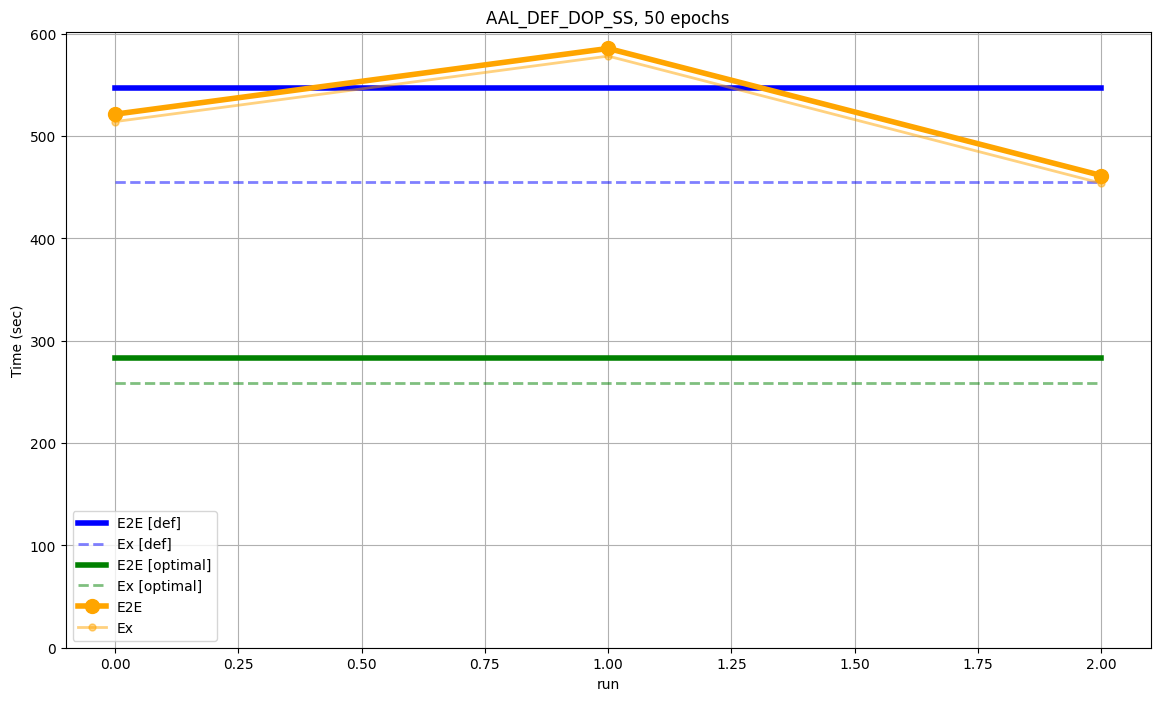

In [415]:
optimum_ex = sum([min([_get_execution_time(q_n, hs, dop) for hs in HINTSETS for dop in [DEFAULT_DOP]]) for q_n in all_queries]), 
optimum_e2e = sum([min([_get_e2e_time(q_n, hs, dop) for hs in HINTSETS for dop in [DEFAULT_DOP]]) for q_n in all_queries]),
visualise(reports, optimum_e2e=optimum_e2e, optimum_ex=optimum_ex, title="AAL_DEF_DOP_SS, 50 epochs")

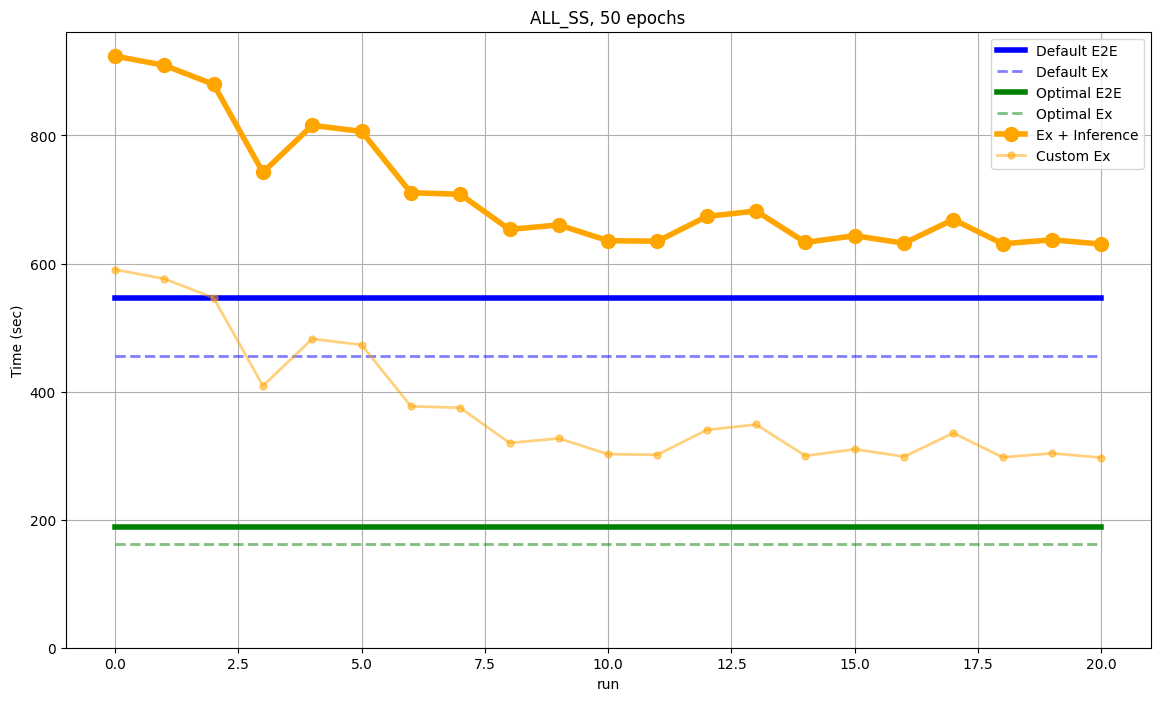

In [380]:
optimum_ex = sum([min([_get_execution_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS]) for q_n in all_queries]), 
optimum_e2e = sum([min([_get_e2e_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS]) for q_n in all_queries]),
visualise(reports, optimum_e2e=optimum_e2e, optimum_ex=optimum_ex, title="ALL_SS, 50 epochs")

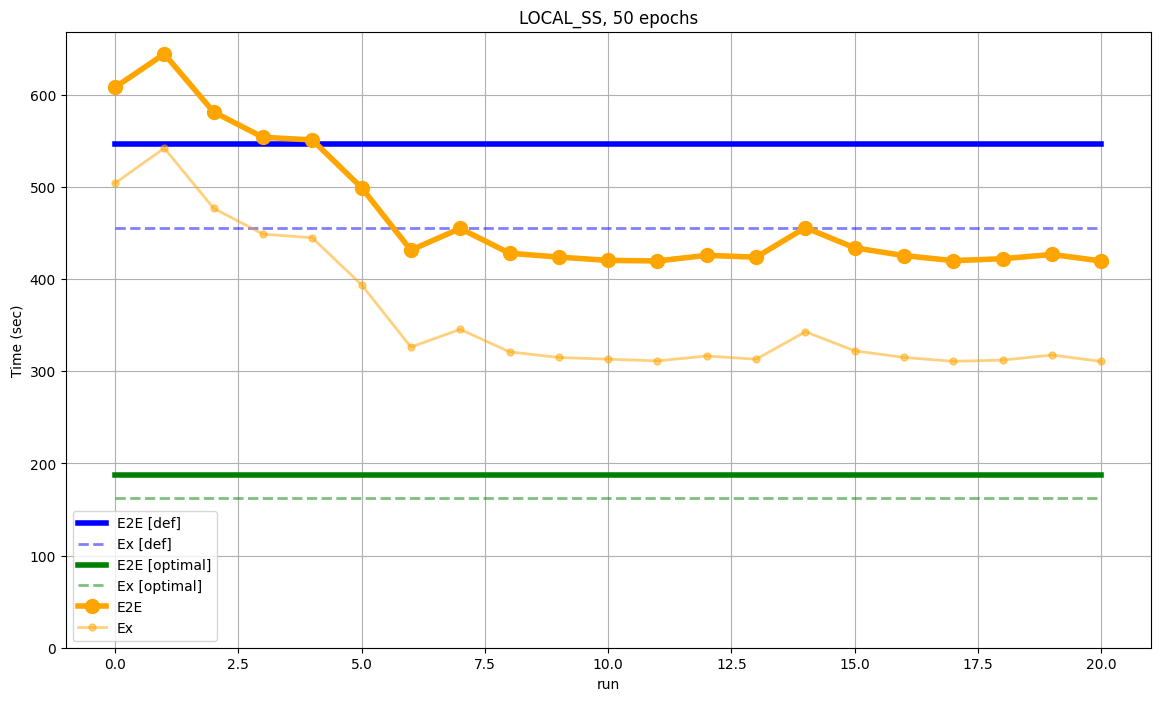

[19.0,
 6.0,
 5.0,
 7.0,
 6.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 7.0,
 4.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 5.0,
 5.0]

In [385]:
optimum_ex = sum([min([_get_execution_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS]) for q_n in all_queries]), 
optimum_e2e = sum([min([_get_e2e_time(q_n, hs, dop) for hs in HINTSETS for dop in DOPS]) for q_n in all_queries]),
visualise(reports, optimum_e2e=optimum_e2e, optimum_ex=optimum_ex, title="LOCAL_SS, 50 epochs")
[r["n_timeouts"] for r in reports]

Results:
- greedy inference helps to tackle the problem of multiple planning
- online learning is expensive and doesn't allow us to reach the optimum
- online learning isn't scalable approach
- model that is learned in online mode still lead to degradations even after 20 iterations over static **workload** (5/113)

In [44]:
reports = []

workload = all_queries
default_history = [(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in workload]
nnmodel = NN(fit_settings=EMPTY_SS, inference_settings=LOCAL_SS._replace(max_iter=1), model=bt_regressor())
nnmodel._add_history(default_history)
nnmodel._update_model(epochs=150)
report = get_report(nnmodel, workload, False)
reports.append(report)

print(f'[run # 0] Default ex {report["default_ex_time"]:0.2f}, Default planning {report["default_planning_time"]:0.2f}, Custom ex {report["custom_ex_time"]:0.2f}, Inference {report["inference_time"]:0.2f}')

for run in range(1, 10):    
    collected_history = report["predictions"]
    nnmodel._add_history(collected_history)
    nnmodel._update_model(epochs=150)
    report = get_report(nnmodel, workload, False)
    reports.append(report)
    print(f'[run # {run}] Default ex {report["default_ex_time"]:0.2f}, Default planning {report["default_planning_time"]:0.2f}, Custom ex {report["custom_ex_time"]:0.2f}, Inference {report["inference_time"]:0.3f}')

Dataset's size is 105 | Dataloader's size is 4


100%|██████████| 113/113 [00:12<00:00,  9.12it/s]


[run # 0] Default ex 455.28, Default planning 91.42, Custom ex 386.58, Inference 211.19
Dataset's size is 189 | Dataloader's size is 6


100%|██████████| 113/113 [00:09<00:00, 12.00it/s]


[run # 1] Default ex 455.28, Default planning 91.42, Custom ex 364.10, Inference 211.191
Dataset's size is 229 | Dataloader's size is 8


100%|██████████| 113/113 [00:09<00:00, 11.99it/s]


[run # 2] Default ex 455.28, Default planning 91.42, Custom ex 360.01, Inference 211.191
Dataset's size is 261 | Dataloader's size is 9


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


[run # 3] Default ex 455.28, Default planning 91.42, Custom ex 324.03, Inference 211.191
Dataset's size is 280 | Dataloader's size is 9


100%|██████████| 113/113 [00:09<00:00, 11.44it/s]


[run # 4] Default ex 455.28, Default planning 91.42, Custom ex 247.07, Inference 211.191
Dataset's size is 290 | Dataloader's size is 10


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


[run # 5] Default ex 455.28, Default planning 91.42, Custom ex 259.23, Inference 211.191
Dataset's size is 299 | Dataloader's size is 10


100%|██████████| 113/113 [00:10<00:00, 11.10it/s]


[run # 6] Default ex 455.28, Default planning 91.42, Custom ex 243.00, Inference 211.191
Dataset's size is 306 | Dataloader's size is 10


100%|██████████| 113/113 [00:09<00:00, 11.64it/s]


[run # 7] Default ex 455.28, Default planning 91.42, Custom ex 272.80, Inference 211.191
Dataset's size is 311 | Dataloader's size is 10


100%|██████████| 113/113 [00:09<00:00, 12.11it/s]


[run # 8] Default ex 455.28, Default planning 91.42, Custom ex 246.78, Inference 211.191
Dataset's size is 315 | Dataloader's size is 10


100%|██████████| 113/113 [00:09<00:00, 12.49it/s]

[run # 9] Default ex 455.28, Default planning 91.42, Custom ex 237.01, Inference 211.191


In [68]:
for run in range(11, 21):    
    collected_history = report["predictions"]
    nnmodel._add_history(collected_history)
    nnmodel._update_model(epochs=150)
    report = get_report(nnmodel, workload, False)
    reports.append(report)
    print(f'[run # {run}] Default ex {report["default_ex_time"]:0.2f}, Default planning {report["default_planning_time"]:0.2f}, Custom ex {report["custom_ex_time"]:0.2f}, Inference {report["inference_time"]:0.3f}')

Dataset's size is 322 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.72it/s]


[run # 11] Default ex 455.28, Default planning 91.42, Custom ex 273.86, Inference 211.191
Dataset's size is 328 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.18it/s]


[run # 12] Default ex 455.28, Default planning 91.42, Custom ex 269.53, Inference 211.191
Dataset's size is 329 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.86it/s]


[run # 13] Default ex 455.28, Default planning 91.42, Custom ex 269.75, Inference 211.191
Dataset's size is 331 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 12.59it/s]


[run # 14] Default ex 455.28, Default planning 91.42, Custom ex 269.54, Inference 211.191
Dataset's size is 331 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 12.99it/s]


[run # 15] Default ex 455.28, Default planning 91.42, Custom ex 269.53, Inference 211.191
Dataset's size is 331 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.50it/s]


[run # 16] Default ex 455.28, Default planning 91.42, Custom ex 269.39, Inference 211.191
Dataset's size is 333 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.34it/s]


[run # 17] Default ex 455.28, Default planning 91.42, Custom ex 269.37, Inference 211.191
Dataset's size is 335 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.00it/s]


[run # 18] Default ex 455.28, Default planning 91.42, Custom ex 269.68, Inference 211.191
Dataset's size is 337 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.57it/s]


[run # 19] Default ex 455.28, Default planning 91.42, Custom ex 270.68, Inference 211.191
Dataset's size is 344 | Dataloader's size is 11


100%|██████████| 113/113 [00:08<00:00, 13.39it/s]

[run # 20] Default ex 455.28, Default planning 91.42, Custom ex 271.62, Inference 211.191


In [382]:
reports = []

workload = all_queries
default_history = [(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in workload]
nnmodel = NN(fit_settings=EMPTY_SS, inference_settings=LOCAL_SS, model=bt_regressor())
nnmodel._add_history(default_history)
nnmodel._update_model(epochs=50)
report = get_report(nnmodel, workload, False)
reports.append(report)
print(f'[run # 0] Default ex {report["default_ex_time"]:0.2f}, Default planning {report["default_planning_time"]:0.2f}, Custom ex {report["custom_ex_time"]:0.2f}, Inference {report["inference_time"]:0.2f}')

for run in range(1, 21):    
    collected_history = report["predictions"]
    nnmodel._add_history(collected_history)
    nnmodel._update_model(epochs=50)
    report = get_report(nnmodel, workload, False)
    reports.append(report)
    print(f'[run # {run}] Default ex {report["default_ex_time"]:0.2f}, Default planning {report["default_planning_time"]:0.2f}, Custom ex {report["custom_ex_time"]:0.2f}, Inference {report["inference_time"]:0.2f}')

Dataset's size is 105 | Dataloader's size is 4


100%|██████████| 113/113 [00:19<00:00,  5.93it/s]


[run # 0] Default ex 455.28, Default planning 91.42, Custom ex 504.16, Inference 6657.18
Dataset's size is 191 | Dataloader's size is 6


100%|██████████| 113/113 [00:19<00:00,  5.93it/s]


[run # 1] Default ex 455.28, Default planning 91.42, Custom ex 542.22, Inference 6546.64
Dataset's size is 245 | Dataloader's size is 8


100%|██████████| 113/113 [00:20<00:00,  5.54it/s]


[run # 2] Default ex 455.28, Default planning 91.42, Custom ex 476.97, Inference 6691.11
Dataset's size is 288 | Dataloader's size is 9


100%|██████████| 113/113 [00:19<00:00,  5.91it/s]


[run # 3] Default ex 455.28, Default planning 91.42, Custom ex 448.95, Inference 6723.40
Dataset's size is 318 | Dataloader's size is 10


100%|██████████| 113/113 [00:19<00:00,  5.78it/s]


[run # 4] Default ex 455.28, Default planning 91.42, Custom ex 444.96, Inference 6798.09
Dataset's size is 344 | Dataloader's size is 11


100%|██████████| 113/113 [00:20<00:00,  5.49it/s]


[run # 5] Default ex 455.28, Default planning 91.42, Custom ex 393.94, Inference 6746.54
Dataset's size is 375 | Dataloader's size is 12


100%|██████████| 113/113 [00:19<00:00,  5.68it/s]


[run # 6] Default ex 455.28, Default planning 91.42, Custom ex 326.31, Inference 6735.69
Dataset's size is 399 | Dataloader's size is 13


100%|██████████| 113/113 [00:21<00:00,  5.37it/s]


[run # 7] Default ex 455.28, Default planning 91.42, Custom ex 345.58, Inference 7008.50
Dataset's size is 417 | Dataloader's size is 14


100%|██████████| 113/113 [00:20<00:00,  5.39it/s]


[run # 8] Default ex 455.28, Default planning 91.42, Custom ex 321.13, Inference 6852.87
Dataset's size is 431 | Dataloader's size is 14


100%|██████████| 113/113 [00:21<00:00,  5.37it/s]


[run # 9] Default ex 455.28, Default planning 91.42, Custom ex 315.02, Inference 6973.97
Dataset's size is 443 | Dataloader's size is 14


100%|██████████| 113/113 [00:20<00:00,  5.40it/s]


[run # 10] Default ex 455.28, Default planning 91.42, Custom ex 313.15, Inference 6862.56
Dataset's size is 444 | Dataloader's size is 14


100%|██████████| 113/113 [00:20<00:00,  5.39it/s]


[run # 11] Default ex 455.28, Default planning 91.42, Custom ex 311.34, Inference 6941.83
Dataset's size is 447 | Dataloader's size is 14


100%|██████████| 113/113 [00:21<00:00,  5.33it/s]


[run # 12] Default ex 455.28, Default planning 91.42, Custom ex 316.62, Inference 6996.33
Dataset's size is 460 | Dataloader's size is 15


100%|██████████| 113/113 [00:21<00:00,  5.21it/s]


[run # 13] Default ex 455.28, Default planning 91.42, Custom ex 313.09, Inference 7087.96
Dataset's size is 468 | Dataloader's size is 15


100%|██████████| 113/113 [00:21<00:00,  5.32it/s]


[run # 14] Default ex 455.28, Default planning 91.42, Custom ex 343.01, Inference 7230.06
Dataset's size is 471 | Dataloader's size is 15


100%|██████████| 113/113 [00:20<00:00,  5.39it/s]


[run # 15] Default ex 455.28, Default planning 91.42, Custom ex 322.19, Inference 7156.57
Dataset's size is 480 | Dataloader's size is 15


100%|██████████| 113/113 [00:20<00:00,  5.41it/s]


[run # 16] Default ex 455.28, Default planning 91.42, Custom ex 315.11, Inference 7073.92
Dataset's size is 485 | Dataloader's size is 16


100%|██████████| 113/113 [00:20<00:00,  5.60it/s]


[run # 17] Default ex 455.28, Default planning 91.42, Custom ex 310.84, Inference 6992.92
Dataset's size is 489 | Dataloader's size is 16


100%|██████████| 113/113 [00:19<00:00,  5.71it/s]


[run # 18] Default ex 455.28, Default planning 91.42, Custom ex 312.18, Inference 7043.89
Dataset's size is 492 | Dataloader's size is 16


100%|██████████| 113/113 [00:20<00:00,  5.45it/s]


[run # 19] Default ex 455.28, Default planning 91.42, Custom ex 317.67, Inference 6985.35
Dataset's size is 503 | Dataloader's size is 16


100%|██████████| 113/113 [00:20<00:00,  5.53it/s]

[run # 20] Default ex 455.28, Default planning 91.42, Custom ex 310.70, Inference 6983.39


In [211]:
with open(f"{ARTIFACTS_PATH}/online_all.json", "w") as f:
    json.dump(reports, f)

## Dynamic benchmark

### Splitting by time

In [68]:
import numpy as np
time_treshold = np.quantile([_get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in all_queries], .8)

In [69]:
time_treshold = np.quantile([_get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in all_queries], .8)
fast_q_n = [q_n for q_n in all_queries if _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) < time_treshold]
slow_q_n = [q_n for q_n in all_queries if _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) >= time_treshold]
assert len(slow_q_n) + len(fast_q_n) == len(all_queries)

In [122]:
nnmodel = NN(fit_settings=ALL_SS, inference_settings=ALL_SS, model=bt_regressor())
learning_time = nnmodel.fit(slow_q_n, epochs=100)
print(f"Learned in {learning_time}\n")

slow_report = get_report(nnmodel, slow_q_n, False)
print(f'Default {slow_report["default_time"]:0.2f}, Custom {slow_report["custom_time"]:0.2f}, Inference {slow_report["inference_time"] / 64:0.2f}')

fast_report = get_report(nnmodel, fast_q_n, False)
print(f'Default {fast_report["default_time"]:0.2f}, Custom {fast_report["custom_time"]:0.2f}, Inference {fast_report["inference_time"] / 64:0.2f}')

Dataset's size is 1658 | Dataloader's size is 7


[100/100] MSE: 2.5614: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Learned in 28164.008353577974



100%|██████████| 23/23 [00:00<00:00, 26.71it/s]


Default 400.18, Custom 149.81, Inference 87.68


100%|██████████| 90/90 [00:09<00:00,  9.59it/s]

Default 146.52, Custom 106.95, Inference 245.72


In [123]:
nnmodel = NN(fit_settings=ALL_SS, inference_settings=ALL_SS, model=bt_regressor())
learning_time = nnmodel.fit(fast_q_n, epochs=100)
print(f"Learned in {learning_time}\n")

fast_report = get_report(nnmodel, fast_q_n, False)
print(f'Default {fast_report["default_time"]:0.2f}, Custom {fast_report["custom_time"]:0.2f}, Inference {fast_report["inference_time"] / 64:0.2f}')

slow_report = get_report(nnmodel, slow_q_n, False)
print(f'Default {slow_report["default_time"]:0.2f}, Custom {slow_report["custom_time"]:0.2f}, Inference {slow_report["inference_time"] / 64:0.2f}')

Dataset's size is 5758 | Dataloader's size is 23


[100/100] MSE: 0.2302: 100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Learned in 24976.15926586505



100%|██████████| 90/90 [00:02<00:00, 40.09it/s]


Default 146.52, Custom 54.08, Inference 245.72


100%|██████████| 23/23 [00:00<00:00, 40.90it/s]

Default 400.18, Custom 568.31, Inference 87.68


### Splitting by structure

In [70]:
logical_trees_to_queries = defaultdict(list)
for q_n in all_queries:
    logical_trees_to_queries[get_logical_tree(_get_explain_plan(q_n, DEFAULT_HINTSET, DEFAULT_DOP))].append(q_n)

In [71]:
def get_traintest_split(groups, ratio, seed=42):
    train, test = [], []
    for group in groups:
        random.seed(seed)
        random.shuffle(group)
        pivot = int(len(group) * ratio)
        train += group[:pivot]
        test += group[pivot:]
        print(f"{group} -> {group[:pivot]}, {group[pivot:]}")
    return train, test

In [72]:
train, test = get_traintest_split([v for v in logical_trees_to_queries.values() if len(v) > 1], ratio=0.8)

['9b', '9a'] -> ['9b'], ['9a']
['6c', '6b', '6f', '2c', '6e', '2a', '2b', '2d', '6d', '6a'] -> ['6c', '6b', '6f', '2c', '6e', '2a', '2b', '2d'], ['6d', '6a']
['4c', '4a', '4b'] -> ['4c', '4a'], ['4b']
['16b', '11c', '16a', '16c', '16d'] -> ['16b', '11c', '16a', '16c'], ['16d']
['3c', '3a', '3b'] -> ['3c', '3a'], ['3b']
['23c', '23a'] -> ['23c'], ['23a']
['30b', '27c'] -> ['30b'], ['27c']
['22b', '22a', '22c'] -> ['22b', '22a'], ['22c']
['8d', '8c'] -> ['8d'], ['8c']
['1a', '1c'] -> ['1a'], ['1c']
['30a', '30c'] -> ['30a'], ['30c']
['31c', '31a', '31b'] -> ['31c', '31a'], ['31b']
['17a', '17e'] -> ['17a'], ['17e']
['1d', '1b'] -> ['1d'], ['1b']
['21b', '25a', '21a', '25c'] -> ['21b', '25a', '21a'], ['25c']
['17f', '17d', '17b', '17c'] -> ['17f', '17d', '17b'], ['17c']
['5b', '5a'] -> ['5b'], ['5a']
['32b', '32a'] -> ['32b'], ['32a']
['7a', '11b'] -> ['7a'], ['11b']
['13c', '13b'] -> ['13c'], ['13b']
['20c', '20b'] -> ['20c'], ['20b']


In [98]:
nnmodel = NN(fit_settings=ALL_SEARCH_SS, inference_settings=ALL_SEARCH_SS, model=bt_regressor())
learning_time = nnmodel.fit(train, epochs=100)
print(f"Learned in {learning_time}\n")

train_report = get_report(nnmodel, train, False)
print(f'Default {train_report["default_time"]:0.2f}, Custom {train_report["custom_time"]:0.2f}, Inference {train_report["inference_time"] / 64:0.2f}')

test_report = get_report(nnmodel, test, False)
print(f'Default {test_report["default_time"]:0.2f}, Custom {test_report["custom_time"]:0.2f}, Inference {test_report["inference_time"] / 64:0.2f}')

Learned in 15095.55614901443



100%|██████████| 39/39 [00:00<00:00, 40.31it/s]


Default 227.66, Custom 109.15, Inference 49.10


100%|██████████| 22/22 [00:00<00:00, 38.03it/s]

Default 106.88, Custom 113.98, Inference 38.78


In [106]:
LOCAL_SEARCH_SS = LOCAL_SEARCH_SS._replace(max_iter=1)

In [108]:
nnmodel.inference_settings = LOCAL_SEARCH_SS
test_report = get_report(nnmodel, test, False)
print(f'Default {test_report["default_time"]:0.2f}, Custom {test_report["custom_time"]:0.2f}, Inference {test_report["inference_time"] / 64:0.2f}')

100%|██████████| 22/22 [00:01<00:00, 14.04it/s]

Default 106.88, Custom 108.80, Inference 6.80


In [414]:
nnmodel = NN(fit_settings=ALL_SEARCH_SS, inference_settings=LOCAL_DEF_DOP_SS._, model=bt_regressor())
learning_time = nnmodel.fit(train, epochs=100)

train_report = get_report(nnmodel, train, False)
print(f'Default {train_report["default_time"]:0.2f}, Custom {train_report["custom_time"]:0.2f}, Inference {train_report["inference_time"] / 64:0.2f}')

test_report = get_report(nnmodel, test, False)
print(f'Default {test_report["default_time"]:0.2f}, Custom {test_report["custom_time"]:0.2f}, Inference {test_report["inference_time"] / 64:0.2f}')

KeyboardInterrupt: 

In [91]:
test_report

{'default_time': 106.88033100000001,
 'custom_time': 82.81228063526392,
 'inference_time': 2482.0660000000003,
 'n_timeouts': 0.0,
 'deltas': [0.037592000000000014,
  9.339472,
  -0.048357999543666846,
  -0.174345014005661,
  0.3142670000000001,
  -0.40742202026748653,
  0.3617220000000001,
  3.240989,
  0.34367899407196045,
  7.962928999999999,
  0.6618330293197632,
  11.975052999999999,
  0.6276829999999998,
  -7.302752000000002,
  1.7312189999999998,
  -14.339430626220702,
  8.600495,
  0.8379300013818739,
  0.0030639999999999973,
  0.04138800000000001,
  0.126016,
  0.135027],
 'predictions': [('9a', 50, 64),
  ('6d', 42, 64),
  ('6a', 26, 64),
  ('4b', 107, 1),
  ('16d', 52, 1),
  ('3b', 90, 1),
  ('23a', 103, 16),
  ('27c', 60, 1),
  ('22c', 55, 1),
  ('8c', 102, 16),
  ('1c', 87, 16),
  ('30c', 42, 1),
  ('31b', 60, 1),
  ('17e', 106, 64),
  ('1b', 81, 1),
  ('25c', 43, 64),
  ('17c', 42, 16),
  ('5a', 42, 16),
  ('32a', 88, 1),
  ('11b', 86, 1),
  ('13b', 47, 1),
  ('20b', 56, 